# Session 4 - Model Selection and Regularization

### Contents

- [Subset Selection](#6.1-Subset-Selection)
- [Shrinkage Methods](#6.2-Shrinkage-Methods)
- [Principal Components Regression](#6.3-Principal-Components-Regression)
- [Partial Least Squares](#6.4-Partial-Least-Squares)

### Labs
- [Subset Selection methods](#6.5-Lab-1:-Subset-Selection-Methods)
- [Ridge Regression and the Lasso](#6.6-Lab-2:-Ridge-Regression-and-the-Lasso)
- [PCR and PLS Regression](#6.7-Lab-3:-PCR-and-PLS-Regression)

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import scale 
from sklearn import model_selection
from sklearn.linear_model import LinearRegression, Ridge, RidgeCV, Lasso, LassoCV
from sklearn.decomposition import PCA
from sklearn.cross_decomposition import PLSRegression
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import mean_squared_error

%matplotlib inline
plt.style.use('seaborn-white')

In [1]:
# Import and setup matplotlib for graphs
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d

%matplotlib inline
plt.style.use('seaborn-white')

## 6.1 Subset Selection

In [2]:
import pandas as pd

# Credit ratings dataset
credit = pd.read_csv('data/Credit.csv', usecols=list(range(1,12)))

In [3]:
credit.head()

,Income,Limit,Rating,Cards,Age,Education,Gender,Student,Married,Ethnicity,Balance
0,14.891,3606,283,2,34,11,Male,No,Yes,Caucasian,333
1,106.025,6645,483,3,82,15,Female,Yes,Yes,Asian,903
2,104.593,7075,514,4,71,11,Male,No,No,Asian,580
3,148.924,9504,681,3,36,11,Female,No,No,Asian,964
4,55.882,4897,357,2,68,16,Male,No,Yes,Caucasian,331


In [4]:
# X and y
X = credit.loc[:, credit.columns != 'Balance']
y = credit.loc[:,'Balance']

In [5]:
import numpy as np
from itertools import combinations
from statsmodels.api import add_constant
from statsmodels.regression.linear_model import OLS

# Init RSS and R2
RSS = np.zeros((0,2))
R2 = np.zeros((0,2))

# Categorical variables 
categ_cols = ["Gender", "Student", "Married", "Ethnicity"]

# Loop over all possible combinations of regressions
K = np.shape(X)[1]
for k in range(K+1):
    for i in combinations(range(K), k):
        
        # Subset X
        X_subset = X.iloc[:,list(i)]
        if k>0:
            cols = list(set(categ_cols) & set(X_subset.columns))
            X_subset = pd.get_dummies(X_subset, columns=cols, drop_first=True)

        # Regress
        reg = OLS(y,add_constant(X_subset)).fit()

        # Metrics
        r2 = np.reshape([k,reg.rsquared], (1,-1))
        R2 = np.append(R2, r2, axis=0)
        rss = np.reshape([k,reg.ssr], (1,-1))
        RSS = np.append(RSS, rss, axis=0)

In [6]:
# Save best scores
R2_best = [np.max(R2[R2[:,0]==k,1]) for k in range(K+1)]
RSS_best = [np.min(RSS[RSS[:,0]==k,1]) for k in range(K+1)]

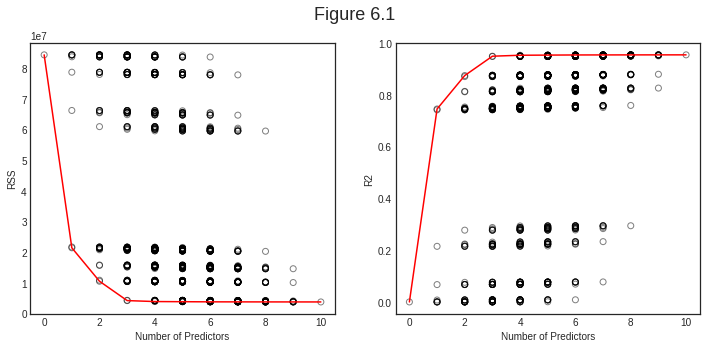

In [7]:
# Figure 6.1
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(12,5))
fig.suptitle('Figure 6.1', fontsize=18)

# MSE
ax1.scatter(x=RSS[:,0], y=RSS[:,1], facecolors='None', edgecolors='k', alpha=0.5);
ax1.plot(range(K+1), RSS_best, c='r');
ax1.set_xlabel('Number of Predictors'); ax1.set_ylabel('RSS');

# R2
ax2.scatter(x=R2[:,0], y=R2[:,1], facecolors='None', edgecolors='k', alpha=0.5);
ax2.plot(range(K+1), R2_best, c='r');
ax2.set_xlabel('Number of Predictors'); ax2.set_ylabel('R2');

In [8]:
# Init metrics
AIC = np.zeros((0,2))
BIC = np.zeros((0,2))
R2_adj = np.zeros((0,2))

# Loop over all possible combinations of regressions
for k in range(K+1):
    for i in combinations(range(K), k):
        
        # Subset X
        X_subset = X.iloc[:,list(i)]
        if k>0:
            cols = list(set(categ_cols) & set(X_subset.columns))
            X_subset = pd.get_dummies(X_subset, columns=cols, drop_first=True)

        # Regress
        reg = OLS(y,add_constant(X_subset)).fit()

        # Advanced Metrics
        aic = np.reshape([k,reg.aic], (1,-1))
        AIC = np.append(AIC, aic, axis=0)
        bic = np.reshape([k,reg.bic], (1,-1))
        BIC = np.append(BIC, bic, axis=0)
        r2_adj = np.reshape([k,reg.rsquared_adj], (1,-1))
        R2_adj = np.append(R2_adj, r2_adj, axis=0)

In [9]:
# Save best scores
AIC_best = [np.min(AIC[AIC[:,0]==k,1]) for k in range(K+1)]
BIC_best = [np.min(BIC[BIC[:,0]==k,1]) for k in range(K+1)]
R2_adj_best = [np.max(R2_adj[R2_adj[:,0]==k,1]) for k in range(K+1)]

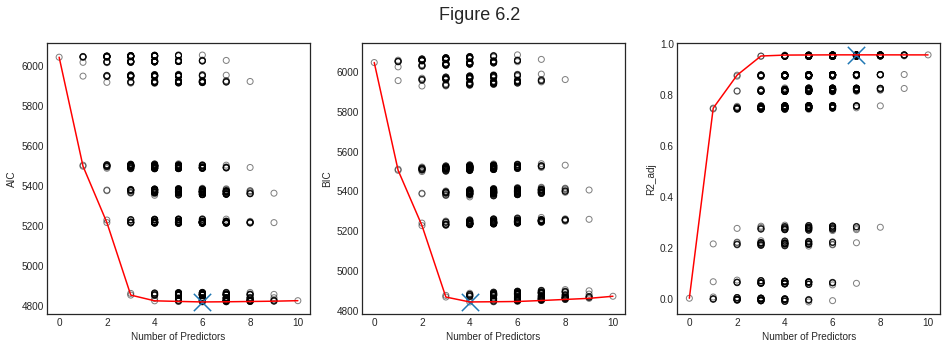

In [10]:
# Figure 6.2
fig, (ax1,ax2,ax3) = plt.subplots(1,3, figsize=(16,5))
fig.suptitle('Figure 6.2', fontsize=18)

# AIC
ax1.scatter(x=AIC[:,0], y=AIC[:,1], facecolors='None', edgecolors='k', alpha=0.5);
ax1.plot(range(K+1),AIC_best, c='r');
ax1.scatter(np.argmin(AIC_best), np.min(AIC_best), marker='x', s=300)
ax1.set_xlabel('Number of Predictors'); ax1.set_ylabel('AIC');

# BIC
ax2.scatter(x=BIC[:,0], y=BIC[:,1], facecolors='None', edgecolors='k', alpha=0.5);
ax2.plot(range(K+1), BIC_best, c='r');
ax2.scatter(np.argmin(BIC_best), np.min(BIC_best), marker='x', s=300)
ax2.set_xlabel('Number of Predictors'); ax2.set_ylabel('BIC');

# R2 adj
ax3.scatter(x=R2_adj[:,0], y=R2_adj[:,1], facecolors='None', edgecolors='k', alpha=0.5);
ax3.plot(range(K+1), R2_adj_best, c='r');
ax3.scatter(np.argmax(R2_adj_best), np.max(R2_adj_best), marker='x', s=300)
ax3.set_xlabel('Number of Predictors'); ax3.set_ylabel('R2_adj');

## 6.2 Shrinkage Methods

### 6.2.1 Ridge Regression

The __glmnet__ algorithms in R optimize the objective function using cyclical coordinate descent, while scikit-learn Ridge regression uses linear least squares with L2 regularization. They are rather different implementations, but the general principles are the same.

The __glmnet() function in R__ optimizes:

$$ 
\frac{1}{N}|| X\beta-y||^2_2+\lambda\bigg(\frac{1}{2}(1−\alpha)||\beta||^2_2 \ +\ \alpha||\beta||_1\bigg) 
$$

(See R documentation and https://cran.r-project.org/web/packages/glmnet/vignettes/glmnet_beta.pdf)
The function supports L1 and L2 regularization. For just Ridge regression we need to use $\alpha = 0 $. This reduces the above cost function to

$$ 
\frac{1}{N}|| X\beta-y||^2_2+\frac{1}{2}\lambda ||\beta||^2_2 
$$
    
The __sklearn Ridge()__ function optimizes:

$$ 
||X\beta - y||^2_2 + \alpha ||\beta||^2_2 
$$

which is equivalent to optimizing

$$ 
\frac{1}{N}||X\beta - y||^2_2 + \frac{\alpha}{N} ||\beta||^2_2 
$$

In [11]:
# X and y
categ_cols = ["Gender", "Student", "Married", "Ethnicity"]
X = credit.loc[:, credit.columns != 'Balance']
X = pd.get_dummies(X, columns=categ_cols, drop_first=True)
y = credit.loc[:,'Balance']
n = len(credit)

In [12]:
from sklearn.linear_model import Ridge
from sklearn.preprocessing import scale 

# Init alpha grid
n_grid = 100
alphas = 10**np.linspace(-2,5,n_grid).reshape(-1,1)
ridge = Ridge()
coefs = []

# Loop over values of alpha
for a in alphas:
    ridge.set_params(alpha=a)
    ridge.fit(scale(X), y)
    coefs.append(ridge.coef_)
coefs = np.reshape(coefs,(n_grid,-1))

In [13]:
from sklearn.linear_model import LinearRegression

# OLS regression
reg = LinearRegression().fit(scale(X),y)
ols_coefs = reg.coef_;

# Relative magnitude
mod_ols = np.linalg.norm(ols_coefs)
rel_beta = [np.linalg.norm(coefs[k,:])/mod_ols for k in range(n_grid)]
rel_beta = np.reshape(rel_beta, (-1,1))

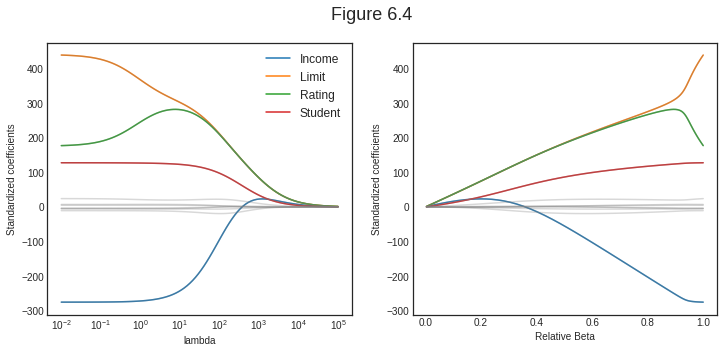

In [14]:
# Figure 6.4
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(12,5))
fig.suptitle('Figure 6.4', fontsize=18)

highlight = [0,1,2,7];

# Plot coefficients - absolute
ax1.plot(alphas, coefs[:,highlight], alpha=1)
ax1.plot(alphas, coefs, c='grey', alpha=0.3)
ax1.set_xscale('log')
ax1.set_xlabel('lambda'); ax1.set_ylabel('Standardized coefficients');
ax1.legend(['Income', 'Limit', 'Rating', 'Student'], fontsize=12)

# Plot coefficients - relative
ax2.plot(rel_beta, coefs[:,highlight], alpha=1)
ax2.plot(rel_beta, coefs, c='grey', alpha=0.3)
ax2.set_xlabel('Relative Beta'); ax2.set_ylabel('Standardized coefficients');


The above plot shows that the Ridge coefficients get larger when we decrease alpha.

In [15]:
from numpy.random import normal as rnorm
np.random.seed(3)

# Generate random data
n = 50
k = 45
k0 = k
X_train = rnorm(0,1,(n,k))
e_train = rnorm(0,k0**0.5,(n,1))
b0 = rnorm(0,1,(k0,1))

# y only depends on the first two columns
y_train = X_train[:,0:k0] @ b0 + e_train

# Test
X_test = rnorm(0,1,(n,k))
e_test = rnorm(0,k0**0.5,(n,1))
f_test = X_test[:,0:k0] @ b0
y_test = f_test + e_test

In [16]:
# Init alpha grid
n_grid = 100
df = pd.DataFrame({'alpha':10**np.linspace(-2,5,n_grid)})
coefs = []

# Loop over values of alpha
for i in range(len(df)):
    a = df.loc[i,'alpha']
    ridge = Ridge(alpha=a).fit(scale(X_train), y_train)
    y_hat = ridge.predict(scale(X_test))
    df.loc[i,'var'] = np.var(y_hat)
    df.loc[i,'mse'] = np.mean((y_test - y_hat)**2)
    df.loc[i,'bias2'] = df.loc[i,'mse'] - df.loc[i,'var'] - np.var(e_test)
    coefs.append(ridge.coef_)
coefs = np.reshape(coefs,(n_grid,-1))

In [17]:
# OLS regression
reg = LinearRegression().fit(scale(X_train),y_train)
ols_coefs = reg.coef_;

# Relative magnitude
mod_ols = np.linalg.norm(ols_coefs)
rel_beta = [np.linalg.norm(coefs[k,:])/mod_ols for k in range(n_grid)]
rel_beta = np.reshape(rel_beta, (-1,1))

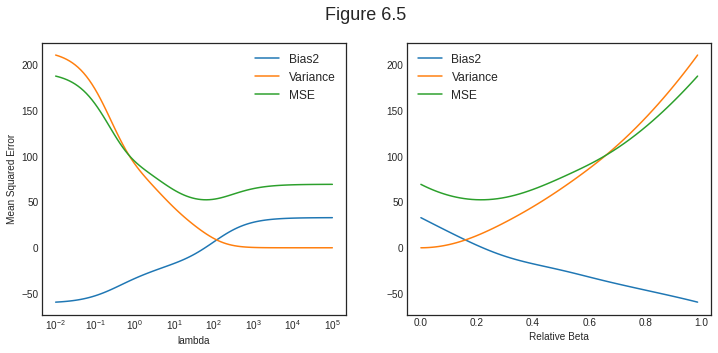

In [18]:
# Figure 6.4
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(12,5))
fig.suptitle('Figure 6.5', fontsize=18)

# MSE
ax1.plot(df['alpha'], df[['bias2','var','mse']]);
ax1.set_xscale('log');
ax1.set_xlabel('lambda'); ax1.set_ylabel('Mean Squared Error');
ax1.legend(['Bias2','Variance','MSE'], fontsize=12);

# MSE
ax2.plot(rel_beta, df[['bias2','var','mse']]);
ax2.set_xlabel('Relative Beta'); ax1.set_ylabel('Mean Squared Error');
ax2.legend(['Bias2','Variance','MSE'], fontsize=12);

### 6.2.2 Lasso

In [19]:
# X and y
categ_cols = ["Gender", "Student", "Married", "Ethnicity"]
X = credit.loc[:, credit.columns != 'Balance']
X = pd.get_dummies(X, columns=categ_cols, drop_first=True)
y = credit.loc[:,'Balance']
n = len(credit)

In [20]:
from sklearn.linear_model import Lasso

# Init alpha grid
n_grid = 100
alphas = 10**np.linspace(0,3,n_grid).reshape(-1,1)
lasso = Lasso()
coefs = []

# Loop over values of alpha
for a in alphas:
    lasso.set_params(alpha=a)
    lasso.fit(scale(X), y)
    coefs.append(lasso.coef_)
coefs = np.reshape(coefs,(n_grid,-1))

In [21]:
# OLS regression
reg = LinearRegression().fit(scale(X),y)
ols_coefs = reg.coef_;

# Relative magnitude
mod_ols = np.linalg.norm(ols_coefs)
rel_beta = [np.linalg.norm(coefs[k,:])/mod_ols for k in range(n_grid)]
rel_beta = np.reshape(rel_beta, (-1,1))

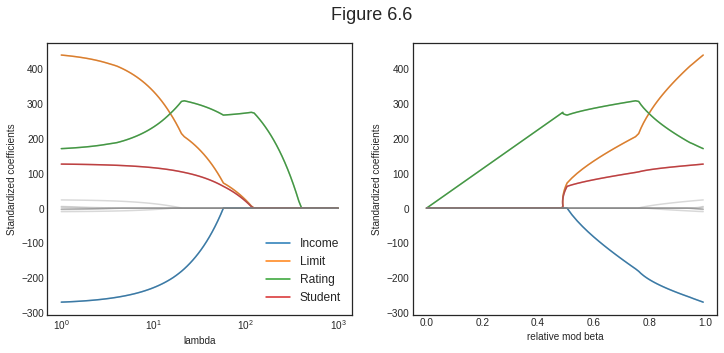

In [22]:
# Figure 6.6
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(12,5))
fig.suptitle('Figure 6.6', fontsize=18)

highlight = [0,1,2,7];

# Plot coefficients - absolute
ax1.plot(alphas, coefs[:,highlight], alpha=1)
ax1.plot(alphas, coefs, c='grey', alpha=0.3)
ax1.set_xscale('log')
ax1.set_xlabel('lambda'); ax1.set_ylabel('Standardized coefficients');
ax1.legend(['Income', 'Limit', 'Rating', 'Student'], fontsize=12)

# Plot coefficients - relative
ax2.plot(rel_beta, coefs[:,highlight], alpha=1)
ax2.plot(rel_beta, coefs, c='grey', alpha=0.3)
ax2.set_xlabel('relative mod beta'); ax2.set_ylabel('Standardized coefficients');


In [23]:
# Init alpha grid
n_grid = 100
df = pd.DataFrame({'alpha':10**np.linspace(-1,1,n_grid)})
coefs = []

# Loop over values of alpha
for i in range(len(df)):
    a = df.loc[i,'alpha']
    lasso = Lasso(alpha=a).fit(scale(X_train), y_train)
    y_hat = lasso.predict(scale(X_test))
    df.loc[i,'var'] = np.var(y_hat)
    df.loc[i,'mse'] = np.mean((y_test - y_hat)**2)
    df.loc[i,'bias2'] = np.mean((y_hat - f_test)**2)
    df.loc[i,'bias2'] = df.loc[i,'mse'] - df.loc[i,'var'] - np.var(e_test)
    coefs.append(lasso.coef_)
coefs = np.reshape(coefs,(n_grid,-1))

In [24]:
# OLS regression
ols_reg = LinearRegression().fit(scale(X_train),y_train)
ols_coefs = ols_reg.coef_;

# Relative magnitude
mod_ols = np.linalg.norm(ols_coefs)
rel_beta = [np.linalg.norm(coefs[k,:])/mod_ols for k in range(n_grid)]
rel_beta = np.reshape(rel_beta, (-1,1))

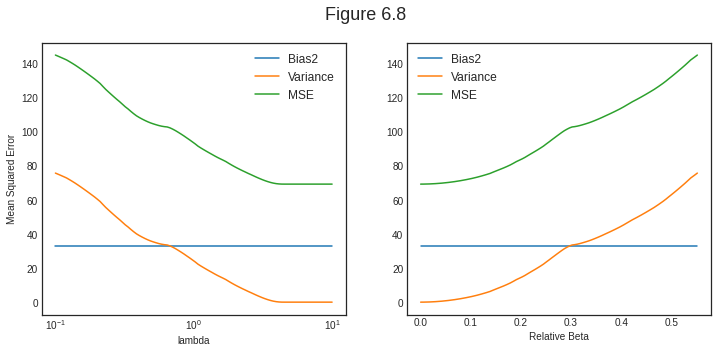

In [25]:
# Figure 6.8
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(12,5))
fig.suptitle('Figure 6.8', fontsize=18)

# MSE
ax1.plot(df['alpha'], df[['bias2','var','mse']]);
ax1.set_xscale('log');
ax1.set_xlabel('lambda'); ax1.set_ylabel('Mean Squared Error');
ax1.legend(['Bias2','Variance','MSE'], fontsize=12);

# MSE
ax2.plot(rel_beta, df[['bias2','var','mse']]);
ax2.set_xlabel('Relative Beta'); ax1.set_ylabel('Mean Squared Error');
ax2.legend(['Bias2','Variance','MSE'], fontsize=12);

In [26]:
from numpy.random import uniform as runi
np.random.seed(3)

# Generate random data
n = 100
k = n
X = np.eye(k)
e = rnorm(0,1,(n,1))
b0 = runi(-1,1,(k,1))
y = X @ b0 + e

In [27]:
# OLS regression
reg = LinearRegression().fit(X,y)
ols_coefs = reg.coef_;

# Ridge regression
ridge = Ridge(alpha=1).fit(X,y)
ridge_coefs = ridge.coef_;

# Ridge regression
lasso = Lasso(alpha=0.01).fit(X,y)
lasso_coefs = lasso.coef_.reshape(1,-1);

# sort
order = np.argsort(y.reshape(1,-1), axis=1)
y_sorted = np.take_along_axis(ols_coefs, order, axis=1) 
ols_coefs = np.take_along_axis(ols_coefs, order, axis=1) 
ridge_coefs = np.take_along_axis(ridge_coefs, order, axis=1) 
lasso_coefs = np.take_along_axis(lasso_coefs, order, axis=1) 

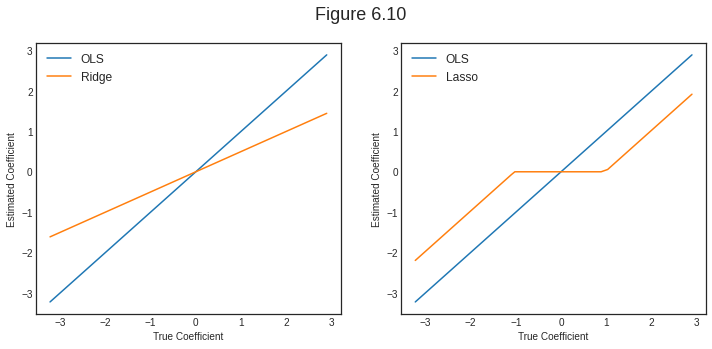

In [28]:
# Figure 6.10
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(12,5))
fig.suptitle('Figure 6.10', fontsize=18)

# Ridge
ax1.plot(y_sorted.T, ols_coefs.T)
ax1.plot(y_sorted.T, ridge_coefs.T)
ax1.set_xlabel('True Coefficient'); ax1.set_ylabel('Estimated Coefficient');
ax1.legend(['OLS','Ridge'], fontsize=12);

# Lasso
ax2.plot(y_sorted.T, ols_coefs.T)
ax2.plot(y_sorted.T, lasso_coefs.T)
ax2.set_xlabel('True Coefficient'); ax2.set_ylabel('Estimated Coefficient');
ax2.legend(['OLS','Lasso'], fontsize=12);

### 6.2.3 Selecting the Tuning Parameter

In [29]:
# X and y
categ_cols = ["Gender", "Student", "Married", "Ethnicity"]
X = credit.loc[:, credit.columns != 'Balance']
X = pd.get_dummies(X, columns=categ_cols, drop_first=True).values
y = credit.loc[:,'Balance']
n = len(credit)

In [30]:
from sklearn.model_selection import LeaveOneOut
from sklearn.metrics import mean_squared_error

# Get Mse Function
def cv_ridge(X,y,a):
    mse = []
    # Generate splits
    loo = LeaveOneOut()
    loo.get_n_splits(X)
    # Loop over splits
    for train_index, test_index in loo.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        ridge = Ridge(alpha=a).fit(X_train, y_train)
        y_hat = ridge.predict(X_test)
        mse.append(mean_squared_error(y_test, y_hat))
    return np.mean(mse)

In [31]:
# Compute MSE over grid of alphas
# WARNING! takes time
n_grid = 30
alphas = 10**np.linspace(-3,1,n_grid).reshape(-1,1)
MSE = [cv_ridge(X,y,a) for a in alphas]

In [32]:
# Find minimum alpha
alpha_min = alphas[np.argmin(MSE)]
print('Best alpha by LOO CV:',alpha_min[0])

Best alpha by LOO CV: 0.16102620275609392


In [33]:
# Get coefficients
coefs = []

# Loop over values of alpha
for a in alphas:
    ridge = Ridge(alpha=a).fit(scale(X), y)
    coefs.append(ridge.coef_)
coefs = np.reshape(coefs,(n_grid,-1))

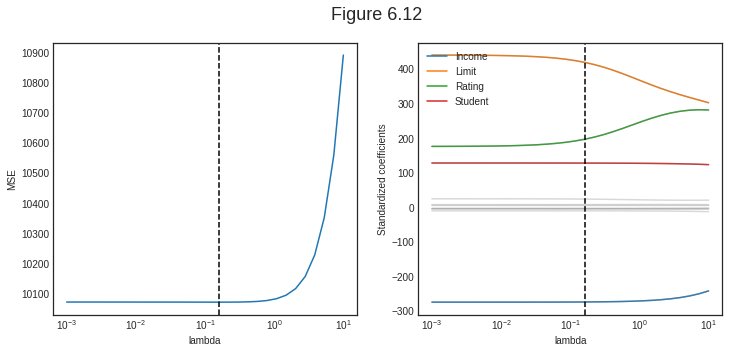

In [34]:
# Figure 6.12
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(12,5))
fig.suptitle('Figure 6.12', fontsize=18)

# MSE by LOO CV
ax1.plot(alphas, MSE, alpha=1);
ax1.axvline(alpha_min, c='k', ls='--')
ax1.set_xscale('log')
ax1.set_xlabel('lambda'); ax1.set_ylabel('MSE');

highlight = [0,1,2,7];

# Plot coefficients - absolute
ax2.plot(alphas, coefs[:,highlight], alpha=1)
ax2.plot(alphas, coefs, c='grey', alpha=0.3)
ax2.axvline(alpha_min, c='k', ls='--')
ax2.set_xscale('log')
ax2.set_xlabel('lambda'); ax2.set_ylabel('Standardized coefficients');
ax2.legend(['Income', 'Limit', 'Rating', 'Student'], fontsize=10);


# Labs

## 6.5 Lab 1: Subset Selection Methods

## 6.5.1 Best Subset Selection

Here we apply the best subset selection approach to the Hitters data. We
wish to predict a baseball player’s Salary on the basis of various statistics
associated with performance in the previous year. Let's take a quick look:

In [36]:
hitters_df = pd.read_csv('data/Hitters.csv')
hitters_df.head()

,Unnamed: 0,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,...,CRuns,CRBI,CWalks,League,Division,PutOuts,Assists,Errors,Salary,NewLeague
0,-Andy Allanson,293,66,1,30,29,14,1,293,66,...,30,29,14,A,E,446,33,20,NaN,A
1,-Alan Ashby,315,81,7,24,38,39,14,3449,835,...,321,414,375,N,W,632,43,10,475.0,N
2,-Alvin Davis,479,130,18,66,72,76,3,1624,457,...,224,266,263,A,W,880,82,14,480.0,A
3,-Andre Dawson,496,141,20,65,78,37,11,5628,1575,...,828,838,354,N,E,200,11,3,500.0,N
4,-Andres Galarraga,321,87,10,39,42,30,2,396,101,...,48,46,33,N,E,805,40,4,91.5,N


First of all, we note that the `Salary` variable is missing for some of the
players. The `isnull()` function can be used to identify the missing observations. It returns a vector of the same length as the input vector, with a `TRUE` value
for any elements that are missing, and a `FALSE` value for non-missing elements.
The `sum()` function can then be used to count all of the missing elements:

In [37]:
print("Number of null values:", hitters_df["Salary"].isnull().sum())

Number of null values: 59


We see that `Salary` is missing for 59 players. The `dropna()` function
removes all of the rows that have missing values in any variable:

In [38]:
# Print the dimensions of the original Hitters data (322 rows x 20 columns)
print("Dimensions of original data:", hitters_df.shape)

# Drop any rows the contain missing values, along with the player names
hitters_df_clean = hitters_df.dropna().iloc[:,1:]

# Print the dimensions of the modified Hitters data (263 rows x 20 columns)
print("Dimensions of modified data:", hitters_df_clean.shape)

# One last check: should return 0
print("Number of null values:", hitters_df_clean["Salary"].isnull().sum())

Dimensions of original data: (322, 21)
Dimensions of modified data: (263, 20)
Number of null values: 0


In [39]:
dummies = pd.get_dummies(hitters_df_clean[['League', 'Division', 'NewLeague']])

y = hitters_df_clean.Salary

# Drop the column with the independent variable (Salary), and columns for which we created dummy variables
X_ = hitters_df_clean.drop(['Salary', 'League', 'Division', 'NewLeague'], axis=1).astype('float64')

# Define the feature set X.
X = pd.concat([X_, dummies[['League_N', 'Division_W', 'NewLeague_N']]], axis=1)

We can perform best subset selection by identifying the best model that contains a given number of predictors, where **best** is quantified using RSS. We'll define a helper function to outputs the best set of variables for
each model size:

In [40]:
def processSubset(feature_set):
    # Fit model on feature_set and calculate RSS
    model = sm.OLS(y,X[list(feature_set)])
    regr = model.fit()
    RSS = ((regr.predict(X[list(feature_set)]) - y) ** 2).sum()
    return {"model":regr, "RSS":RSS}

In [41]:
def getBest(k):
    
    tic = time.time()
    
    results = []
    
    for combo in itertools.combinations(X.columns, k):
        results.append(processSubset(combo))
    
    # Wrap everything up in a nice dataframe
    models = pd.DataFrame(results)
    
    # Choose the model with the highest RSS
    best_model = models.loc[models['RSS'].argmin()]
    
    toc = time.time()
    print("Processed", models.shape[0], "models on", k, "predictors in", (toc-tic), "seconds.")
    
    # Return the best model, along with some other useful information about the model
    return best_model

This returns a `DataFrame` containing the best model that we generated, along with some extra information about the model. Now we want to call that function for each number of predictors $k$:

In [ ]:
import time
import itertools
import statsmodels.api as sm

# Could take quite awhile to complete...
models_best = pd.DataFrame(columns=["RSS", "model"])

tic = time.time()
for i in range(1,8):
    models_best.loc[i] = getBest(i)

toc = time.time()
print("Total elapsed time:", (toc-tic), "seconds.")

Processed 19 models on 1 predictors in 0.036908864974975586 seconds.
Processed 171 models on 2 predictors in 0.2701709270477295 seconds.
Processed 969 models on 3 predictors in 1.4503803253173828 seconds.
Processed 3876 models on 4 predictors in 5.712931156158447 seconds.
Processed 11628 models on 5 predictors in 17.479186058044434 seconds.


Now we have one big `DataFrame` that contains the best models we've generated along with their RSS:

In [ ]:
models_best

If we want to access the details of each model, no problem! We can get a full rundown of a single model using the `summary()` function:

In [ ]:
print(models_best.loc[2, "model"].summary())

This output indicates that the best two-variable model
contains only `Hits` and `CRBI`. To save time, we only generated results
up to the best 7-variable model. You can use the functions we defined above to explore as many variables as are desired.

In [ ]:
# Show the best 19-variable model (there's actually only one)
print(getBest(19)["model"].summary())

Rather than letting the results of our call to the `summary()` function print to the screen, we can access just the parts we need using the model's attributes. For example, if we want the $R^2$ value:

In [ ]:
models_best.loc[2, "model"].rsquared

Excellent! In addition to the verbose output we get when we print the summary to the screen, fitting the `OLM` also produced many other useful statistics such as adjusted $R^2$, AIC, and BIC. We can examine these to try to select the best overall model. Let's start by looking at $R^2$ across all our models:

In [ ]:
# Gets the second element from each row ('model') and pulls out its rsquared attribute
models_best.apply(lambda row: row[1].rsquared, axis=1)

As expected, the $R^2$ statistic increases monotonically as more
variables are included.

Plotting RSS, adjusted $R^2$, AIC, and BIC for all of the models at once will
help us decide which model to select. Note the `type="l"` option tells `R` to
connect the plotted points with lines:

In [ ]:
plt.figure(figsize=(20,10))
plt.rcParams.update({'font.size': 18, 'lines.markersize': 10})

# Set up a 2x2 grid so we can look at 4 plots at once
plt.subplot(2, 2, 1)

# We will now plot a red dot to indicate the model with the largest adjusted R^2 statistic.
# The argmax() function can be used to identify the location of the maximum point of a vector
plt.plot(models_best["RSS"])
plt.xlabel('# Predictors')
plt.ylabel('RSS')

# We will now plot a red dot to indicate the model with the largest adjusted R^2 statistic.
# The argmax() function can be used to identify the location of the maximum point of a vector

rsquared_adj = models_best.apply(lambda row: row[1].rsquared_adj, axis=1)

plt.subplot(2, 2, 2)
plt.plot(rsquared_adj)
plt.plot(rsquared_adj.argmax(), rsquared_adj.max(), "or")
plt.xlabel('# Predictors')
plt.ylabel('adjusted rsquared')

# We'll do the same for AIC and BIC, this time looking for the models with the SMALLEST statistic
aic = models_best.apply(lambda row: row[1].aic, axis=1)

plt.subplot(2, 2, 3)
plt.plot(aic)
plt.plot(aic.argmin(), aic.min(), "or")
plt.xlabel('# Predictors')
plt.ylabel('AIC')

bic = models_best.apply(lambda row: row[1].bic, axis=1)

plt.subplot(2, 2, 4)
plt.plot(bic)
plt.plot(bic.argmin(), bic.min(), "or")
plt.xlabel('# Predictors')
plt.ylabel('BIC')

Recall that in the second step of our selection process, we narrowed the field down to just one model on any $k<=p$ predictors. We see that according to BIC, the best performer is the model with 6 variables. According to AIC and adjusted $R^2$ something a bit more complex might be better. Again, no one measure is going to give us an entirely accurate picture... but they all agree that a model with 5 or fewer predictors is insufficient.

### 6.5.2 Forward and Backward Stepwise Selection

We can also use a similar approach to perform forward stepwise
or backward stepwise selection, using a slight modification of the functions we defined above:

In [ ]:
def forward(predictors):

    # Pull out predictors we still need to process
    remaining_predictors = [p for p in X.columns if p not in predictors]
    
    tic = time.time()
    
    results = []
    
    for p in remaining_predictors:
        results.append(processSubset(predictors+[p]))
    
    # Wrap everything up in a nice dataframe
    models = pd.DataFrame(results)
    
    # Choose the model with the highest RSS
    best_model = models.loc[models['RSS'].argmin()]
    
    toc = time.time()
    print("Processed ", models.shape[0], "models on", len(predictors)+1, "predictors in", (toc-tic), "seconds.")
    
    # Return the best model, along with some other useful information about the model
    return best_model

Now let's see how much faster it runs!

In [ ]:
models_fwd = pd.DataFrame(columns=["RSS", "model"])

tic = time.time()
predictors = []

for i in range(1,len(X.columns)+1):    
    models_fwd.loc[i] = forward(predictors)
    predictors = models_fwd.loc[i]["model"].model.exog_names

toc = time.time()
print("Total elapsed time:", (toc-tic), "seconds.")

Phew! That's a lot better. Let's take a look:

In [ ]:
print(models_fwd.loc[1, "model"].summary())
print(models_fwd.loc[2, "model"].summary())

We see that using forward stepwise selection, the best one-variable
model contains only `Hits`, and the best two-variable model additionally
includes `CRBI`. Let's see how the models stack up against best subset selection:

In [ ]:
print(models_best.loc[6, "model"].summary())
print(models_fwd.loc[6, "model"].summary())

For this data, the best one-variable through six-variable
models are each identical for best subset and forward selection.

#### Backward Selection

Not much has to change to implement backward selection... just looping through the predictors in reverse!

In [ ]:
def backward(predictors):
    
    tic = time.time()
    
    results = []
    
    for combo in itertools.combinations(predictors, len(predictors)-1):
        results.append(processSubset(combo))
    
    # Wrap everything up in a nice dataframe
    models = pd.DataFrame(results)
    
    # Choose the model with the highest RSS
    best_model = models.loc[models['RSS'].argmin()]
    
    toc = time.time()
    print("Processed ", models.shape[0], "models on", len(predictors)-1, "predictors in", (toc-tic), "seconds.")
    
    # Return the best model, along with some other useful information about the model
    return best_model

In [ ]:
models_bwd = pd.DataFrame(columns=["RSS", "model"], index = range(1,len(X.columns)))

tic = time.time()
predictors = X.columns

while(len(predictors) > 1):  
    models_bwd.loc[len(predictors)-1] = backward(predictors)
    predictors = models_bwd.loc[len(predictors)-1]["model"].model.exog_names

toc = time.time()
print("Total elapsed time:", (toc-tic), "seconds.")

For this data, the best one-variable through six-variable
models are each identical for best subset and forward selection.
However, the best seven-variable models identified by forward stepwise selection,
backward stepwise selection, and best subset selection are different:

In [ ]:
print("------------")
print("Best Subset:")
print("------------")
print(models_best.loc[7, "model"].params)

In [ ]:
print("-----------------")
print("Foward Selection:")
print("-----------------")
print(models_fwd.loc[7, "model"].params)

In [ ]:
print("-------------------")
print("Backward Selection:")
print("-------------------")
print(models_bwd.loc[7, "model"].params)

## 6.6 Lab 2: Ridge Regression and the Lasso

We will use the `sklearn` package in order to perform ridge regression and
the lasso. The main functions in this package that we care about are `Ridge()`, which can be used
to fit ridge regression models, and `Lasso()` which will fit lasso models. They also have cross-validated counterparts: `RidgeCV()` and `LassoCV()`. We'll use these a bit later.

Before proceeding, let's first ensure that the missing values have
been removed from the data, as described in the previous lab.

In [ ]:
df = pd.read_csv('data/Hitters.csv').dropna().iloc[:,1:]
df.info()
dummies = pd.get_dummies(df[['League', 'Division', 'NewLeague']])

We will now perform ridge regression and the lasso in order to predict `Salary` on
the `Hitters` data. Let's set up our data:

In [ ]:
y = df.Salary

# Drop the column with the independent variable (Salary), and columns for which we created dummy variables
X_ = df.drop(['Salary', 'League', 'Division', 'NewLeague'], axis = 1).astype('float64')

# Define the feature set X.
X = pd.concat([X_, dummies[['League_N', 'Division_W', 'NewLeague_N']]], axis = 1)

X.info()

### 6.6.1 Ridge Regression

The `Ridge()` function has an alpha argument ($\lambda$, but with a different name!) that is used to tune the model. We'll generate an array of alpha values ranging from very big to very small, essentially
covering the full range of scenarios from the null model containing
only the intercept, to the least squares fit:

In [ ]:
alphas = 10**np.linspace(10,-2,100)*0.5
alphas

Associated with each alpha value is a vector of ridge regression coefficients, which we'll
store in a matrix `coefs`. In this case, it is a $19 \times 100$
matrix, with 19 rows (one for each predictor) and 100
columns (one for each value of alpha). Remember that we'll want to standardize the
variables so that they are on the same scale. To do this, we can use the
`normalize = True` parameter:

In [ ]:
ridge = Ridge(normalize = True)
coefs = []

for a in alphas:
    ridge.set_params(alpha = a)
    ridge.fit(X, y)
    coefs.append(ridge.coef_)
    
np.shape(coefs)

We expect the coefficient estimates to be much smaller, in terms of $l_2$ norm,
when a large value of alpha is used, as compared to when a small value of alpha is
used. Let's plot and find out:

In [ ]:
ax = plt.gca()
ax.plot(alphas, coefs)
ax.set_xscale('log')
plt.axis('tight')
plt.xlabel('alpha')
plt.ylabel('weights')

We now split the samples into a training set and a test set in order
to estimate the test error of ridge regression and the lasso:

In [ ]:
from sklearn.model_selection import train_test_split

# Split data into training and test sets
X_train, X_test , y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=1)

Next we fit a ridge regression model on the training set, and evaluate
its MSE on the test set, using $\lambda = 4$:

In [ ]:
ridge2 = Ridge(alpha = 4, normalize = True)
ridge2.fit(X_train, y_train)             # Fit a ridge regression on the training data
pred2 = ridge2.predict(X_test)           # Use this model to predict the test data
print(pd.Series(ridge2.coef_, index = X.columns)) # Print coefficients
print(mean_squared_error(y_test, pred2))          # Calculate the test MSE

The test MSE when alpha = 4 is 106216. Now let's see what happens if we use a huge value of alpha, say $10^{10}$:

In [ ]:
ridge3 = Ridge(alpha = 10**10, normalize = True)
ridge3.fit(X_train, y_train)             # Fit a ridge regression on the training data
pred3 = ridge3.predict(X_test)           # Use this model to predict the test data
print(pd.Series(ridge3.coef_, index = X.columns)) # Print coefficients
print(mean_squared_error(y_test, pred3))          # Calculate the test MSE

This big penalty shrinks the coefficients to a very large degree, essentially reducing to a model containing just the intercept. This over-shrinking makes the model more biased, resulting in a higher MSE.

Okay, so fitting a ridge regression model with alpha = 4 leads to a much lower test
MSE than fitting a model with just an intercept. We now check whether
there is any benefit to performing ridge regression with alpha = 4 instead of
just performing least squares regression. Recall that least squares is simply
ridge regression with alpha = 0.

In [ ]:
ridge2 = Ridge(alpha = 0, normalize = True)
ridge2.fit(X_train, y_train)             # Fit a ridge regression on the training data
pred = ridge2.predict(X_test)            # Use this model to predict the test data
print(pd.Series(ridge2.coef_, index = X.columns)) # Print coefficients
print(mean_squared_error(y_test, pred))           # Calculate the test MSE

It looks like we are indeed improving over regular least-squares!

Instead of arbitrarily choosing alpha $ = 4$, it would be better to
use cross-validation to choose the tuning parameter alpha. We can do this using
the cross-validated ridge regression function, `RidgeCV()`. By default, the function
performs generalized cross-validation (an efficient form of LOOCV), though this can be changed using the
argument `cv`.

In [ ]:
from sklearn.linear_model import RidgeCV

ridgecv = RidgeCV(alphas = alphas, scoring = 'neg_mean_squared_error', normalize = True)
ridgecv.fit(X_train, y_train)
ridgecv.alpha_

Therefore, we see that the value of alpha that results in the smallest cross-validation
error is 0.57. What is the test MSE associated with this value of
alpha?

In [ ]:
ridge4 = Ridge(alpha = ridgecv.alpha_, normalize = True)
ridge4.fit(X_train, y_train)
mean_squared_error(y_test, ridge4.predict(X_test))

This represents a further improvement over the test MSE that we got using
alpha $ = 4$. Finally, we refit our ridge regression model on the full data set,
using the value of alpha chosen by cross-validation, and examine the coefficient
estimates.

In [ ]:
ridge4.fit(X, y)
pd.Series(ridge4.coef_, index = X.columns)

As expected, none of the coefficients are exactly zero - ridge regression does not
perform variable selection!

# 6.6.2 The Lasso
We saw that ridge regression with a wise choice of alpha can outperform least
squares as well as the null model on the Hitters data set. We now ask
whether the lasso can yield either a more accurate or a more interpretable
model than ridge regression. In order to fit a lasso model, we'll
use the `Lasso()` function; however, this time we'll need to include the argument `max_iter = 10000`.
Other than that change, we proceed just as we did in fitting a ridge model:

In [ ]:
lasso = Lasso(max_iter = 10000, normalize = True)
coefs = []

for a in alphas:
    lasso.set_params(alpha=a)
    lasso.fit(scale(X_train), y_train)
    coefs.append(lasso.coef_)
    
ax = plt.gca()
ax.plot(alphas*2, coefs)
ax.set_xscale('log')
plt.axis('tight')
plt.xlabel('alpha')
plt.ylabel('weights')

Notice that in the coefficient plot that depending on the choice of tuning
parameter, some of the coefficients are exactly equal to zero. We now
perform 10-fold cross-validation to choose the best alpha, refit the model, and compute the associated test error:

In [ ]:
from sklearn.linear_model import LassoCV

lassocv = LassoCV(alphas = None, cv = 10, max_iter = 100000, normalize = True)
lassocv.fit(X_train, y_train)

lasso.set_params(alpha=lassocv.alpha_)
lasso.fit(X_train, y_train)
mean_squared_error(y_test, lasso.predict(X_test))

This is substantially lower than the test set MSE of the null model and of
least squares, and only a little worse than the test MSE of ridge regression with alpha
chosen by cross-validation.

However, the lasso has a substantial advantage over ridge regression in
that the resulting coefficient estimates are sparse. Here we see that 13 of
the 19 coefficient estimates are exactly zero:

In [ ]:
# Some of the coefficients are now reduced to exactly zero.
pd.Series(lasso.coef_, index=X.columns)

## 6.7 Lab 3: PCR and PLS Regression

### 6.7.1 Principal Components Regression

Principal components regression (PCR) can be performed using the `PCA()`
function, which is part of the `sklearn` library. In this lab, we'll apply PCR to the `Hitters`
data, in order to predict `Salary`. As in previous labs, we'll start by ensuring that the missing values have
been removed from the data:

In [ ]:
df = pd.read_csv('data/Hitters.csv').dropna().iloc[:,1:]
df.info()
dummies = pd.get_dummies(df[['League', 'Division', 'NewLeague']])

Let's set up our data:

In [ ]:
y = df.Salary

# Drop the column with the independent variable (Salary), and columns for which we created dummy variables
X_ = df.drop(['Salary', 'League', 'Division', 'NewLeague'], axis=1).astype('float64')

# Define the feature set X.
X = pd.concat([X_, dummies[['League_N', 'Division_W', 'NewLeague_N']]], axis=1)

Unfortunately `sklearn` does not have an implementation of PCA and regression combined like the `pls`, package in R: https://cran.r-project.org/web/packages/pls/vignettes/pls-manual.pdf so we'll have to do it ourselves.

We'll start by performing Principal Components Analysis (PCA), remembering to scale the data:

In [ ]:
from sklearn.decomposition import PCA

pca = PCA()
X_reduced = pca.fit_transform(scale(X))

Let's print out the first few variables of the first few principal components:

In [ ]:
pd.DataFrame(pca.components_.T).loc[:4,:5]

Now we'll perform 10-fold cross-validation to see how it influences the MSE:

In [ ]:
from sklearn.model_selection import KFold, cross_val_score

# 10-fold CV, with shuffle
n = len(X_reduced)
kf_10 = KFold(n_splits=n, shuffle=True, random_state=1)

regr = LinearRegression()
mse = []

# Calculate MSE with only the intercept (no principal components in regression)
score = -1*cross_val_score(regr, np.ones((n,1)), y.ravel(), cv=kf_10, scoring='neg_mean_squared_error').mean()    
mse.append(score)

# Calculate MSE using CV for the 19 principle components, adding one component at the time.
for i in np.arange(1, 20):
    score = -1*cross_val_score(regr, X_reduced[:,:i], y.ravel(), cv=kf_10, scoring='neg_mean_squared_error').mean()
    mse.append(score)

In [ ]:
 # Plot results    
plt.plot(mse, '-v')
plt.xlabel('Number of principal components in regression')
plt.ylabel('MSE')
plt.title('Salary')
plt.xlim(xmin=-1);

We see that the smallest cross-validation error occurs when $M = 18$ components
are used. This is barely fewer than $M = 19$, which amounts to
simply performing least squares, because when all of the components are
used in PCR no dimension reduction occurs. However, from the plot we
also see that the cross-validation error is roughly the same when only one
component is included in the model. This suggests that a model that uses
just a small number of components might suffice.

We'll do a little math to get the amount of variance explained by adding each consecutive principal component:

In [ ]:
np.cumsum(np.round(pca.explained_variance_ratio_, decimals=4)*100)

We'll dig deeper into this concept in Chapter 10, but for now we can think of this as the amount of information about the predictors or the response that is captured using $M$ principal components. For example,
setting $M = 1$ only captures 38.31% of all the variance, or information, in
the predictors. In contrast, using $M = 6$ increases the value to 88.63%. If
we were to use all $M = p = 19$ components, this would increase to 100%.

Now let's perform PCA on the training data and evaluate its test set
performance:

In [ ]:
pca2 = PCA()

# Split into training and test sets
X_train, X_test , y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=1)

# Scale the data
X_reduced_train = pca2.fit_transform(scale(X_train))
n = len(X_reduced_train)

# 10-fold CV, with shuffle
kf_10 = KFold(n_splits=10, shuffle=True, random_state=1)

mse = []

# Calculate MSE with only the intercept (no principal components in regression)
score = -1*cross_val_score(regr, np.ones((n,1)), y_train.ravel(), cv=kf_10, scoring='neg_mean_squared_error').mean()    
mse.append(score)

# Calculate MSE using CV for the 19 principle components, adding one component at the time.
for i in np.arange(1, 20):
    score = -1*cross_val_score(regr, X_reduced_train[:,:i], y_train.ravel(), cv=kf_10, scoring='neg_mean_squared_error').mean()
    mse.append(score)

plt.plot(np.array(mse), '-v')
plt.xlabel('Number of principal components in regression')
plt.ylabel('MSE')
plt.title('Salary')
plt.xlim(xmin=-1);

We find that the lowest cross-validation error occurs when $M = 6$
components are used. Now we'll see how it performs on the test data and compute the test MSE as follows:

In [ ]:
X_reduced_test = pca2.transform(scale(X_test))[:,:7]

# Train regression model on training data 
regr = LinearRegression()
regr.fit(X_reduced_train[:,:7], y_train)

# Prediction with test data
pred = regr.predict(X_reduced_test)
mean_squared_error(y_test, pred)

This test set MSE is competitive with the results obtained using ridge regression
and the lasso. However, as a result of the way PCR is implemented,
the final model is more difficult to interpret because it does not perform
any kind of variable selection or even directly produce coefficient estimates.

### 6.7.2 Partial Least Squares

Scikit-learn `PLSRegression` gives same results as the `pls` package in R when using `method='oscorespls'`. However, the standard method used is `'kernelpls'`, which we'll use here. Feel free to try out both.

In [ ]:
from sklearn.cross_decomposition import PLSRegression, PLSSVD

n = len(X_train)

# 10-fold CV, with shuffle
kf_10 = KFold(n_splits=10, shuffle=True, random_state=1)

mse = []

for i in np.arange(1, 20):
    pls = PLSRegression(n_components=i)
    score = cross_val_score(pls, scale(X_train), y_train, cv=kf_10, scoring='neg_mean_squared_error').mean()
    mse.append(-score)

In [ ]:
# Plot results
plt.plot(np.arange(1, 20), np.array(mse), '-v')
plt.xlabel('Number of principal components in regression')
plt.ylabel('MSE')
plt.title('Salary')
plt.xlim(xmin=-1)

The lowest cross-validation error occurs when only $M = 2$ partial least
squares dimensions are used. We now evaluate the corresponding test set
MSE:

In [ ]:
pls = PLSRegression(n_components=2)
pls.fit(scale(X_train), y_train)

mean_squared_error(y_test, pls.predict(scale(X_test)))

The test MSE is again comparable to the test MSE
obtained using ridge regression, the lasso, and PCR.

## Next Lecture

Jump to [Session 6 - Convexity and optimization](https://nbviewer.jupyter.org/github/matteocourthoud/Machine-Learning-for-Economic-Analysis-2020/blob/master/6_convexity.ipynb)